# Projet 3MA201 encadré par Barbaras Gris
## Groupe Yddir, Garance, Victor, Thomas N

# Implémentation python de la solution de l'appariement inexact dans le cas des petites déformations (rapport de Thomas Nguyen pour le 21/02/2023)

Numéro étudiant : 28626005

Mail : thomas.nguyen@etu.sorbonne-universite.fr ou tstlnguyen@gmail.com

<div class="alert alert-block alert-info">
Ce rapport étant surtout mon support de travail pour ces deux dernières semaines, désolé d'avance du manque de mise en forme et de la rédaction impropre !
Ce notebook étant écrit dans la continuité du dernier, il est assez redondant : je vais signaler les nouvelles choses par une boîte comme celle-ci pour fluidifier la lecture.
</div>

Je remets le lien du site où l'on peut trouver des données : http://ubee.enseeiht.fr/ShapesDataset/

## Contexte

Se référer aux deux premiers rapports de de séance pour plus de précisions. Je me contente d'écrire ce qui m'aidera pour la suite, sans être rigoureux.

Avec un appariement $\varphi$ tel que $\varphi \cdot S = T$, on cherche : $inf\{{c(\varphi) +  \lambda Dist({\varphi \cdot S},T)})^2\}$.

On se restreint au cas des petites déformations, telles qu'avec un champ de vecteurs $V \in \mathscr{C}^{n}(\mathbb{R}^2,\mathbb{R}^2)$ on écrive $\varphi = I_2 + v$, $v \in V$ et $c(\alpha) = |v|^2 _V$.

Ainsi, $\varphi \cdot S = (x_1 + v(x_1), ..., x_n + v(x_n))$.

Pour l'implémentation, on va considérer une grille $(Z_{k})_{K\in [[1;D ]]}$ de points deux-à-deux distincts et $V = \{ x \mapsto \displaystyle\sum_{k=1} ^{D} \alpha_k e^{\frac{-|x-z_{k}|^2}{2\sigma^{2}}}| \alpha_k \in \mathbb{R}^2 , k \in [[1,D]]\} $ avec $\sigma >0$.

On va faire une descente de gradient sur :  
$$J : \alpha = (\alpha_1 , ..., \alpha_D) \in (\mathbb{R}^2)^D \mapsto \displaystyle\sum_{k=1} ^{D} |\alpha_k|^2 + \lambda Dist(\varphi_\alpha \cdot S,T)^2 $$

Où : $\varphi_\alpha = I_2 + \displaystyle\sum_{k=1} ^{D} \displaystyle\sum_{l=1} ^{2} v_{k,l}^{\alpha_k (l)}$ et $v_k : x \mapsto e^{\frac{-|x-z_{k}|^2}{2\sigma^{2}}}e_l$ avec $e_1 = (1,0), e_2 = (0,1)$

In [130]:
import math
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

## Distance

On peut choisir d'utiliser la distance euclidienne, mais considérons plutôt :

Avec $A = (a_1 , ... , a_n)$ et $B = (b_1 , ... , b_n)$ deux listes de $n$ points de $\mathbb{R}^2$,

$$Dist(A,B) = \max\{\max_{i}{(\min_{j}{|a_i - b_j|})}, {\max_{j}{(\min_{i}{|a_i - b_j|})}\}}$$

In [490]:
def maxmin(A,B): # max sur les i du min sur les j, avec A et B des listes de 2-uplets
    
    if len(A) != len(B):
        raise Exception("A et B n'ont pas le même nombre de points !")
        
    max_list = []
    for a in A:
        min_list = []
        for b in B:
            c = (a[0]-b[0],a[1]-b[1])
            min_list.append(np.linalg.norm(c))
        max_list.append(np.min(min_list))
    return np.max(max_list)


def dist(A,B):
    return max(maxmin(A,B),maxmin(B,A))

## Grille

Il faut se choisir une grille $(Z_{k})_{K\in [[1;D ]]}$ de points deux-à-deux distincts.
Pour l'instant, je vais choisir le même pas $\epsilon$ verticalement et horizontalement.
Je compte les points de la grille à partir d'en bas à gauche jusqu'à atteindre le point en haut à droite. 

<div class="alert alert-block alert-info">
Mise à jour : grille avec des points colorés pour mieux visualiser les futures déformations, possibilité de changer la taille de la figure et des axes
</div>

[[0.  0. ]
 [0.  0.5]
 [0.  1. ]
 [0.5 0. ]
 [0.5 0.5]
 [0.5 1. ]
 [1.  0. ]
 [1.  0.5]
 [1.  1. ]]


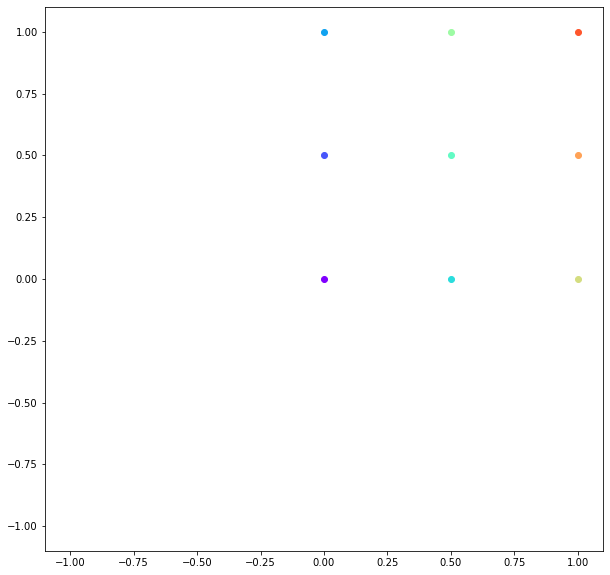

In [491]:
def grille(pas, gauche=-1, droite=1): # post-seance2 : regarder les négatifs aussi finalement, et 
    g = [] 
    for x in np.arange(gauche,droite+pas,pas): # à x fixé, on compte donc en montant colonne par colonne 
        for y in np.arange(gauche,droite+pas,pas):
            g.append((x,y))
    return np.array(g) # post-seance2 : modification en array

def dessiner_grille(G, taille): # avec G liste de 2-uplets, taille pour la taille du cadre de la figure
    X = [] ; Y = []
    for i in range(len(G)):
        X.append(G[i][0])
        Y.append(G[i][1])
        
    #taille = np.max(G)*1.1 # si jamais on veut enlever le paramètre taille...
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(-taille, taille)
    ax.set_ylim(-taille, taille)
    
    p = len(G)
    for i in range(0,p):
        k = i/p # à partir du numéro d'indice de chaque point, on associe un nombre entre 0 et 1 pour assigner une couleur avec cm.get_cmap de matplotlib
        plt.plot(X[i],Y[i], marker= 'o', linestyle='none', color=plt.cm.get_cmap("rainbow")(k))
    plt.show
    
    
# test avec un pas de 0.5, pour le carré [0,1] on a bien neuf points dans l'ordre attendu 
print(grille(0.5,0))
dessiner_grille(grille(0.5,0),1.1)


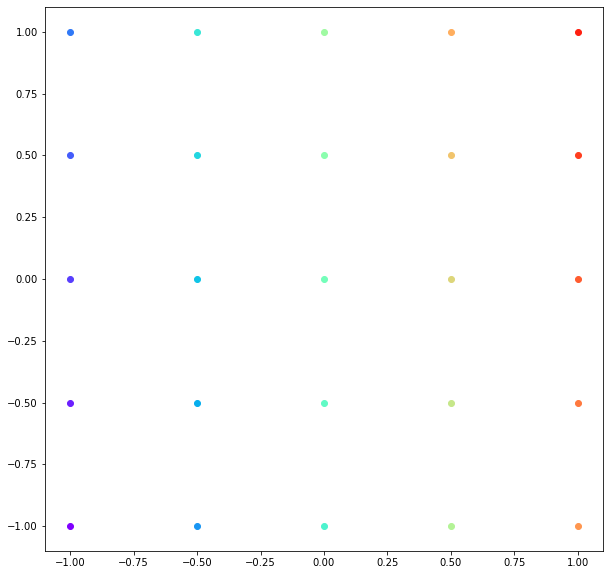

In [492]:
dessiner_grille(grille(0.5),1.1)

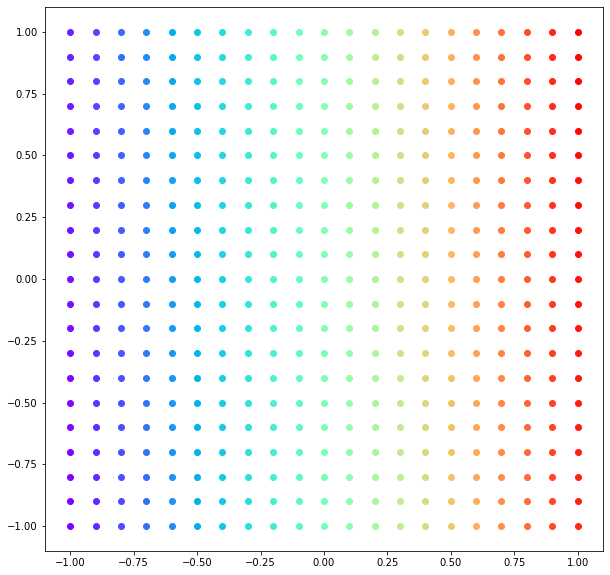

In [493]:
dessiner_grille(grille(0.1),1.1)

<div class="alert alert-block alert-info">
On veut déformer la grille. À partir d'une fonction f, il faut que je l'évalue aux points de la grille.
</div>

In [494]:
def deform_grille(fonc, grille):
    return [fonc(x,y) for (x,y) in grille]

In [495]:
def f1(x,y): #fonction au hasard juste pour tester
    return ((x - 1) ** 3 + (y - 2) ** 2, x ** 2 + y ** 2)

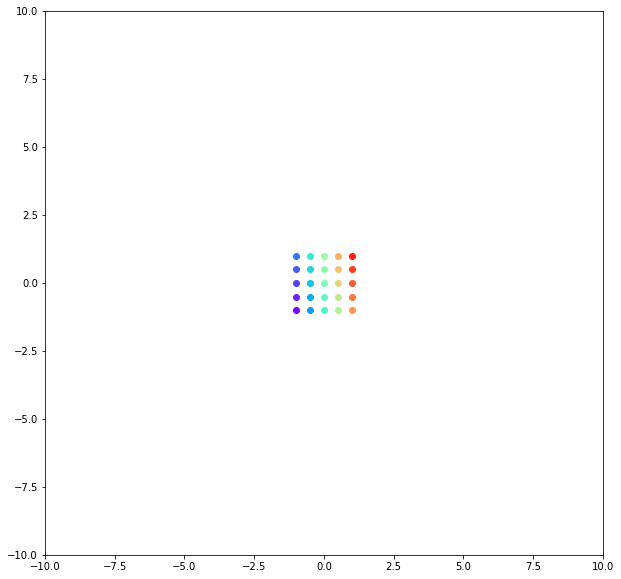

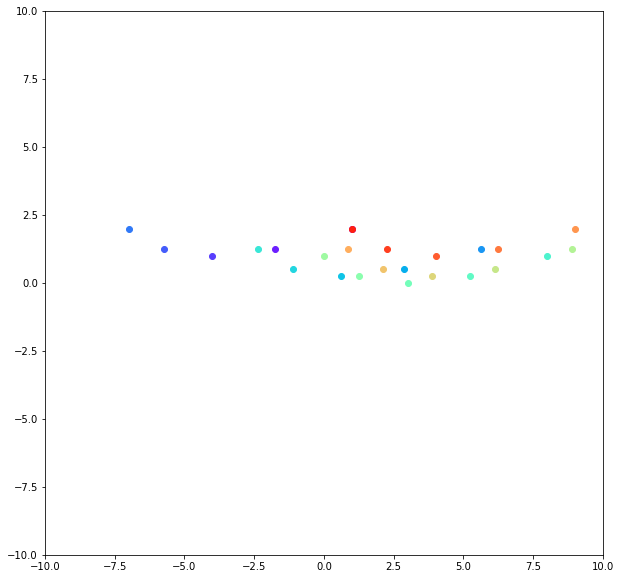

In [496]:
dessiner_grille(grille(0.5),10)
dessiner_grille(deform_grille(f1, grille(0.5)),10)

<div class="alert alert-block alert-info">
Je recommence : avec des lignes colorées pour un peu voir autrement la déformation qu'on veut appliquer. Je n'arrive pas à relier correctement les points de la définiton grille précédente, je repars de zéro et je vais plutôt considérer des lignes verticales et horizontales définies avec np.linspace, qu'on plie avec plus ou moins de précision.
Je considère qu'on déforme donc une grille cartésienne, une "grille bien carrée", qu'on pourra visualiser avec la fonction identité.
</div>

In [497]:
def vraie_grille(fonc, xmin, xmax, ymin, ymax, n_lignes, n_points_ligne):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    lignes = []
    
    for x in np.linspace(xmin, xmax, n_lignes): #à x fixé, donc on itère sur les lignes verticales
        lignes.append([fonc(x,y) for y in np.linspace(ymin, ymax, n_points_ligne)]) #on remplit la ligne
    for y in np.linspace(ymin, ymax, n_lignes): #à y fixé, donc on itère sur les lignes horizontales
        lignes.append([fonc(x,y) for x in np.linspace(xmin, xmax, n_points_ligne)])
    
    i = 0
    p = len(lignes)
    for l in lignes:
        k = i/p # à partir du numéro d'indice de chaque ligne, on associe un nombre entre 0 et 1 pour assigner une couleur avec cm.get_cmap de matplotlib
        a,b = zip(*l) #extraire les abscisses et ordonnées 
        i = i + 1
        plt.plot(a,b,color=plt.cm.get_cmap("rainbow")(k))

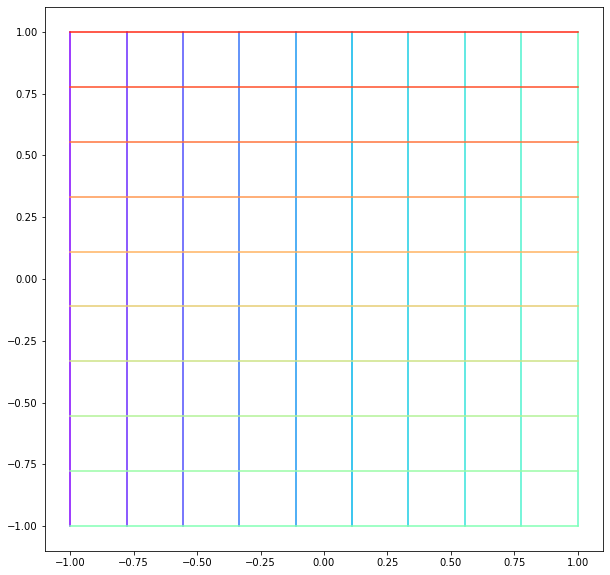

In [498]:
def iden(x,y):
    return x,y
vraie_grille(iden, -1, 1, -1, 1, 10, 10)

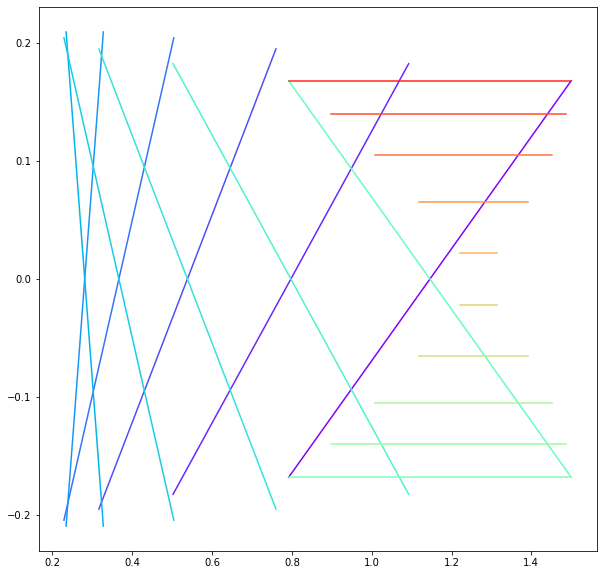

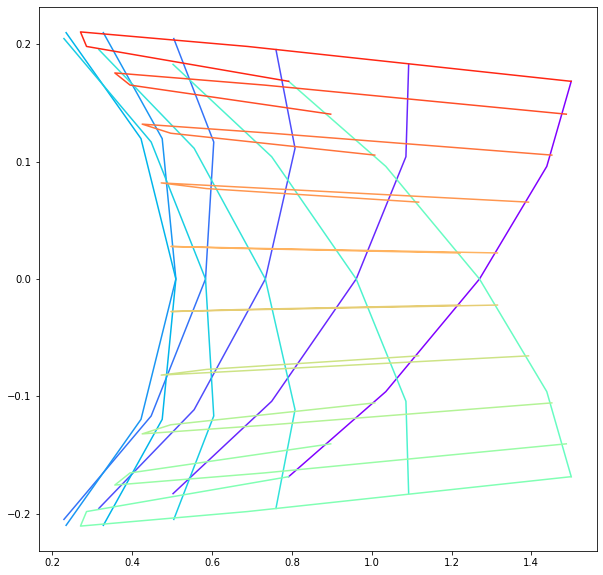

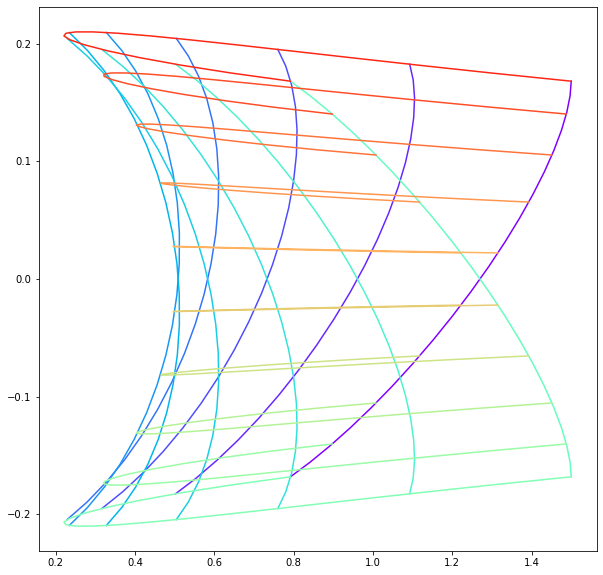

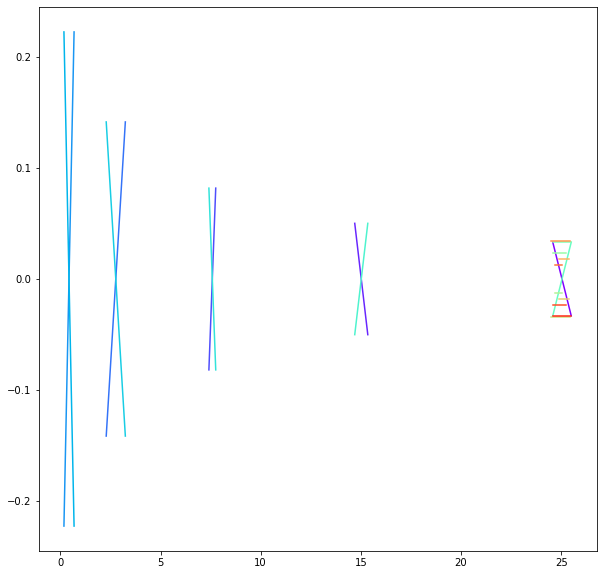

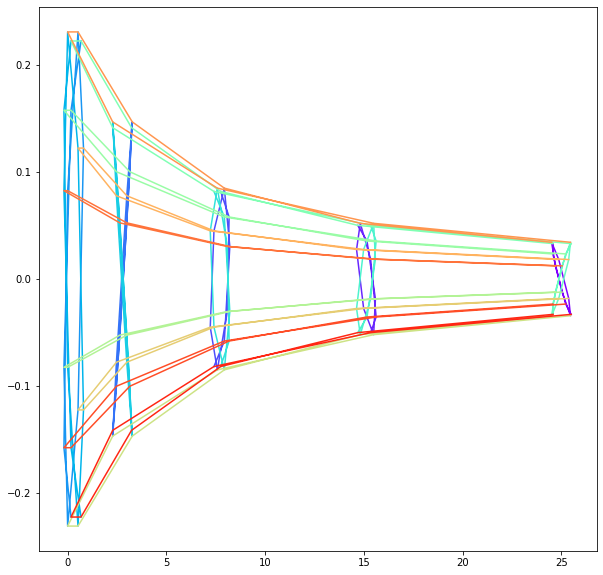

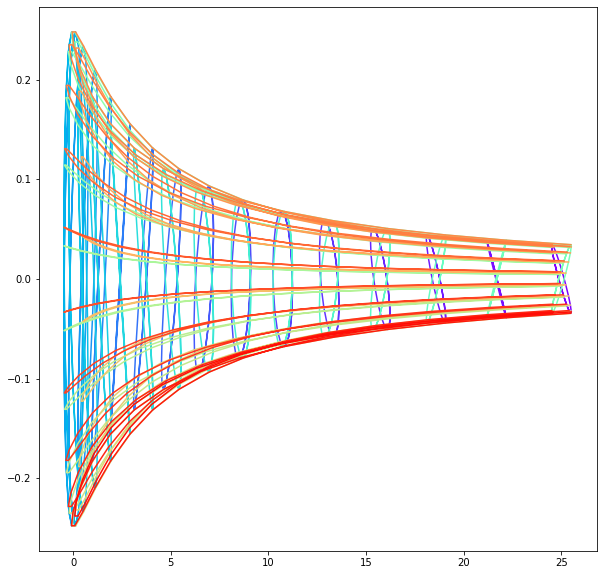

In [499]:
def f2(x,y): #avec des fonctions trigo un peu au hasard
    return 0.5*np.cos(x+y)+x**2, np.sin(y)/(x**2+4)

# on varie n_points_ligne
vraie_grille(f2, -1, 1, -1, 1, 10, 2)
vraie_grille(f2, -1, 1, -1, 1, 10, 5)
vraie_grille(f2, -1, 1, -1, 1, 10, 20)

# on étend le domaine de définition
vraie_grille(f2, -5, 5, -5, 5, 10, 2)
vraie_grille(f2, -5, 5, -5, 5, 10, 10)
vraie_grille(f2, -5, 5, -5, 5, 30, 30)

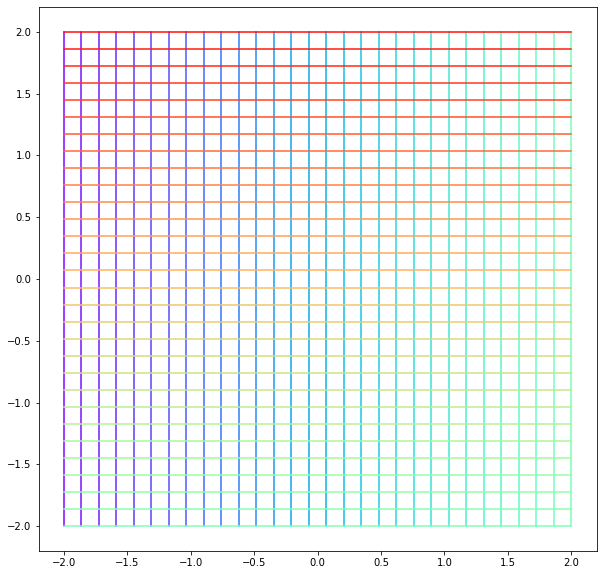

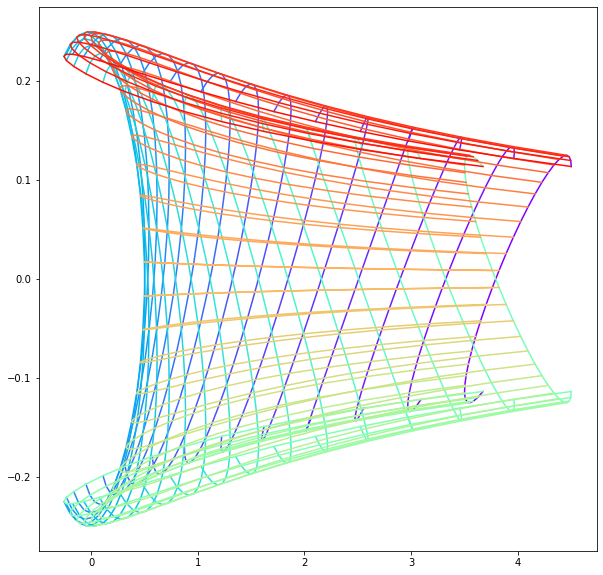

In [500]:
vraie_grille(iden, -2, 2, -2, 2, 30, 30)
vraie_grille(f2, -2, 2, -2, 2, 30, 30)

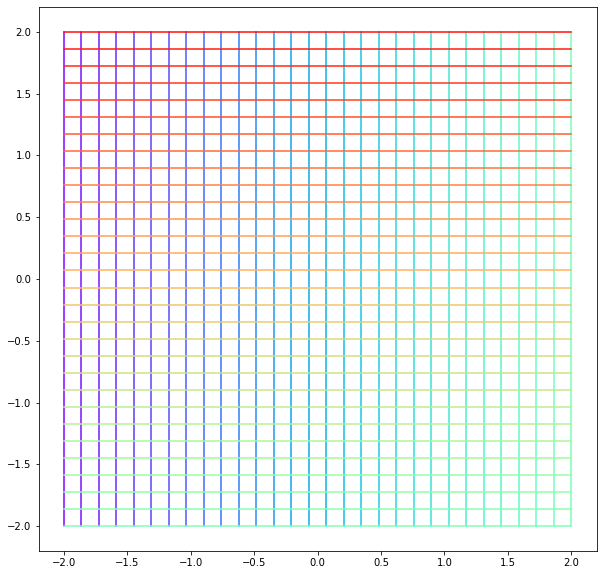

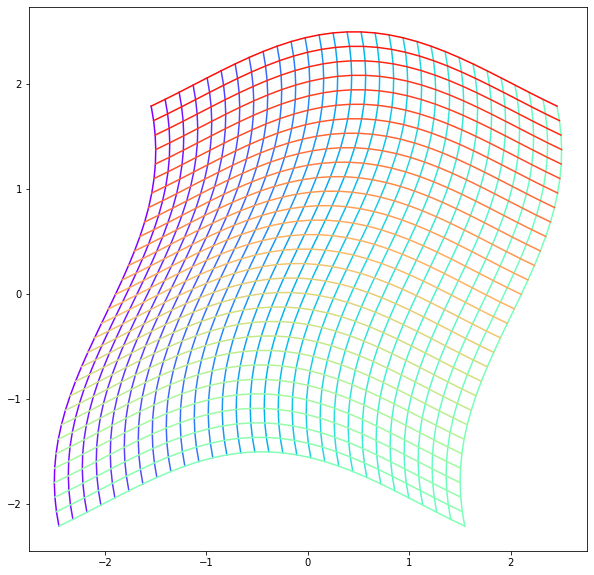

In [501]:
def f3(x,y):
    return x + 0.5*np.sin(y), y + 0.5*np.cos(x)
vraie_grille(iden, -2, 2, -2, 2, 30, 30)
vraie_grille(f3, -2, 2, -2, 2, 30, 30)

<div class="alert alert-block alert-info">
Sur ce dernier exemple, la déformation a l'air plus raisonnable que les autres.
Ce qu'il reste à faire : regarder les cas de non bijectivité, voir quand cela est le cas ou non et chercher des conditions (à connecter avec le travail de Garance). Je n'ai pas réussi à trouver un créneau commun ces deux dernières semaines pour travailler ensemble et en discuter.
</div>

## Champ de vecteurs V

Rappel : $V = \{ x \mapsto \displaystyle\sum_{k=1} ^{D} \alpha_k e^{\frac{-|x-z_{k}|^2}{2\sigma^{2}}}| \alpha_k \in \mathbb{R}^2 , k \in [[1,D]]\} $ avec $\sigma >0$

Pour dessiner le champ de vecteurs je vais devoir refaire une grille avec la fonction meshgrid de Numpy, dans le but d'utiliser la fonction quiver pour la représentation graphique.

In [502]:
def dessinV(Lalpha, G, pas, sigma, gauche=-1, droite=1): 
    # Lalpha est la liste des alpha_k 
    # G une grille dans le sens liste de points comme au-dessus
    # sigma positif
    
    D = len(Lalpha)
    h = int(1.0/pas)
    x,y = np.meshgrid(np.linspace(gauche, droite, h),np.linspace(gauche, droite, h))
    
    v1 = 0
    for k in range(0,D):
        temp = G[k]
        v1 += Lalpha[k][0] * np.exp(((-1)*(np.sqrt(((x-temp[0])**2)+(y-temp[1])**2))/(2*(sigma**2)))) # post-seance2 : correction, il n'y avait pas les bonnes dimensions. cela semble mieux en évitant la fonction np.linalg.norm, j'ai utilisé la norme euclidienne ici
    v2 = 0
    for k in range(0,D):
        temp = G[k]
        v2 += Lalpha[k][1] * np.exp(((-1)*(np.sqrt(((x-temp[0])**2)+(y-temp[1])**2))/(2*(sigma**2))))
        
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.quiver(x, y, v1, v2)
    plt.title("Avec sigma ="+str(sigma))
    plt.show()

In [340]:
Liste_al = np.random.randn(36,2) #liste des alpha, choix au hasard

In [503]:
Liste_al

array([[ 1.05634561,  1.53175387],
       [ 0.31077178, -0.57567669],
       [ 1.7485506 , -0.36999166],
       [-0.34051235, -1.42388816],
       [ 1.62465034,  0.85310191],
       [-0.43927534, -1.32763865],
       [ 1.84744598, -1.55114164],
       [ 0.76712336,  0.83263434],
       [ 1.54254201, -0.14640335],
       [-0.09901536, -0.40217553],
       [-1.12007458, -0.65307392],
       [ 1.42422816,  0.9936219 ],
       [ 0.50752136,  0.25491836],
       [ 0.19843487, -1.71424021],
       [-0.35130245, -1.30751075],
       [ 0.56346938, -2.41553523],
       [ 0.70159941,  0.62060727],
       [-0.73229028, -1.36887127],
       [ 1.59096067,  1.42396627],
       [ 2.02480934, -0.20759221],
       [ 0.26604759, -0.89935054],
       [-0.56681396, -1.74146614],
       [-0.37836037,  1.35288695],
       [-1.2205391 ,  1.50700706],
       [ 0.92803574, -0.26227206],
       [-0.08616629, -1.44535028],
       [-0.14784294, -0.80038639],
       [ 0.55286088, -0.0878061 ],
       [ 0.68557941,

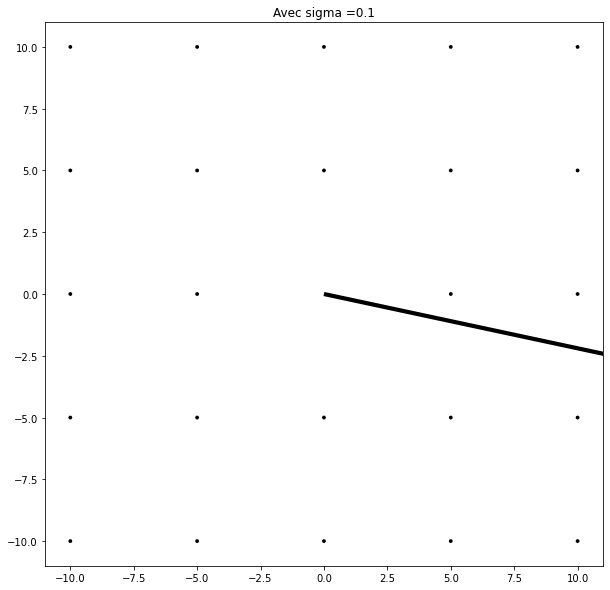

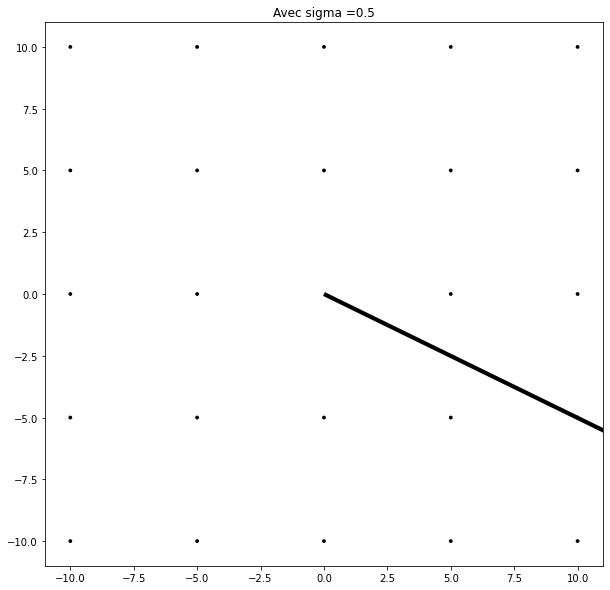

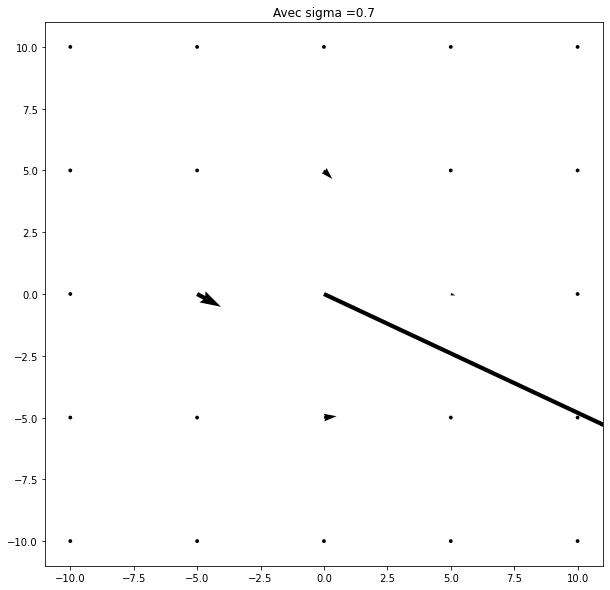

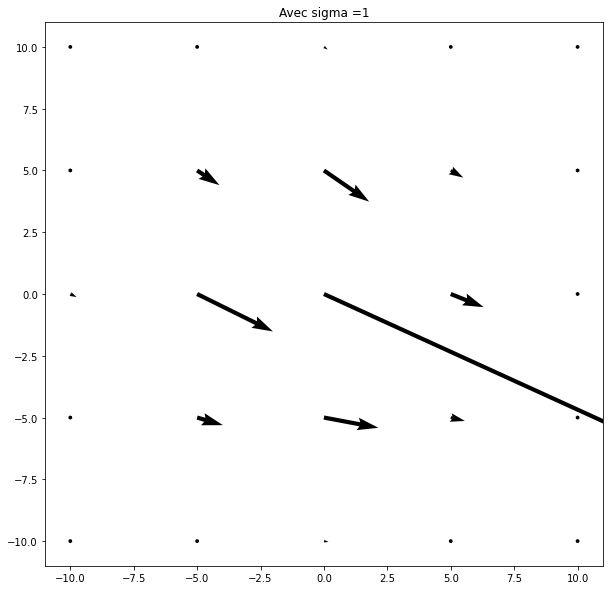

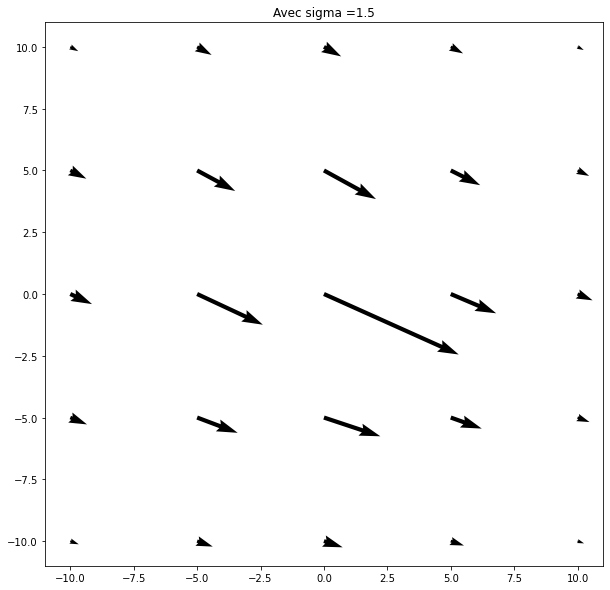

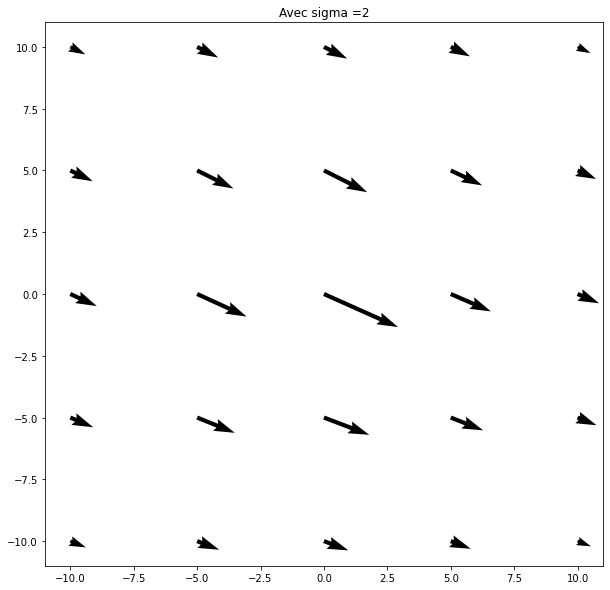

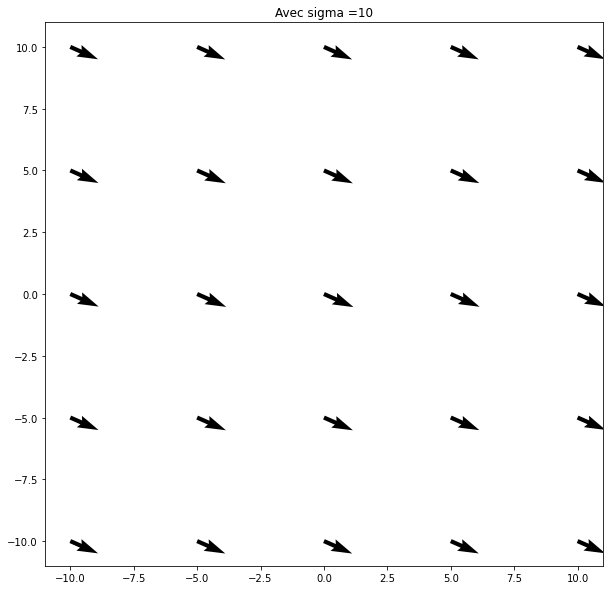

In [504]:
dessinV(Liste_al, grille(0.2), 0.2, 0.1, -10, 10)
dessinV(Liste_al, grille(0.2), 0.2, 0.5, -10, 10)
dessinV(Liste_al, grille(0.2), 0.2, 0.7, -10, 10)
dessinV(Liste_al, grille(0.2), 0.2, 1, -10, 10)
dessinV(Liste_al, grille(0.2), 0.2, 1.5, -10, 10)
dessinV(Liste_al, grille(0.2), 0.2, 2, -10, 10)
dessinV(Liste_al, grille(0.2), 0.2, 10, -10, 10)

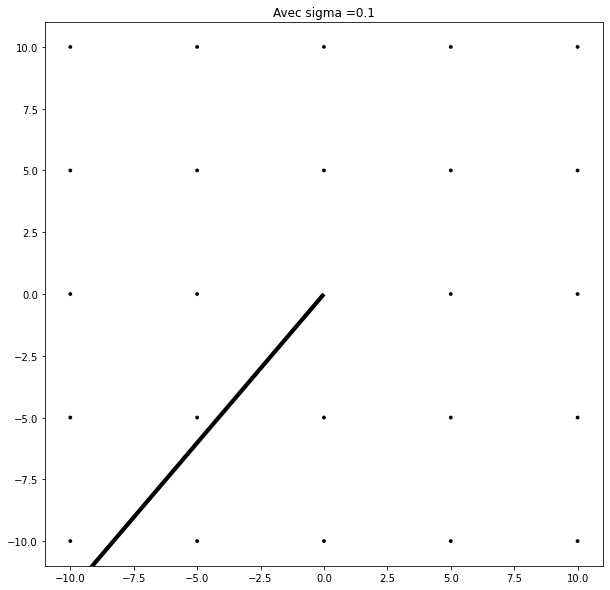

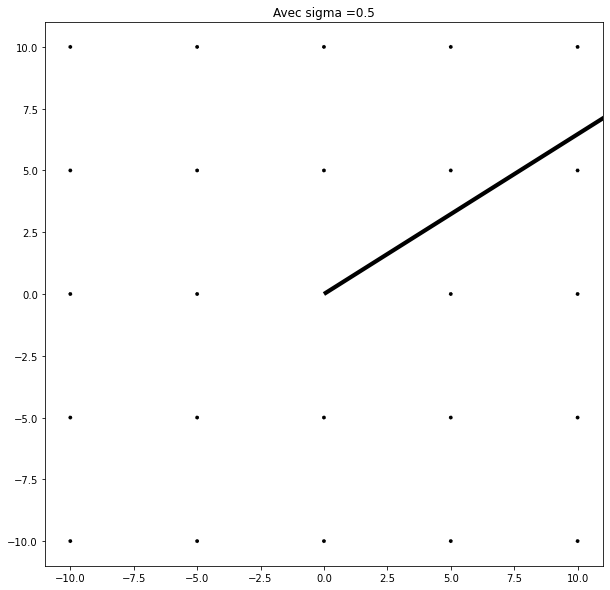

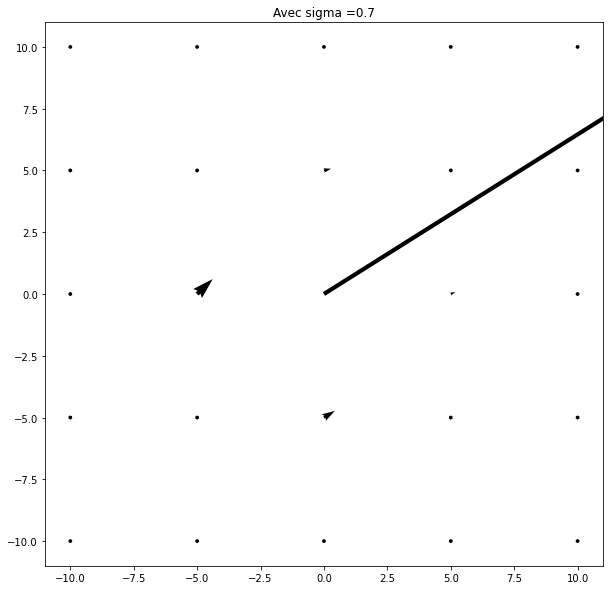

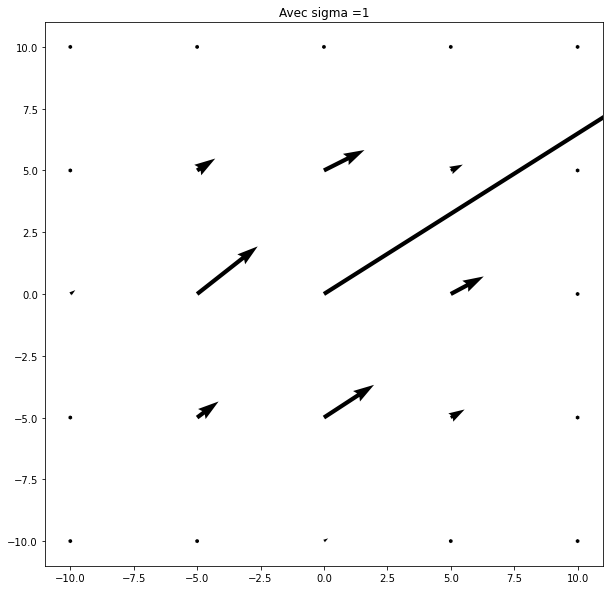

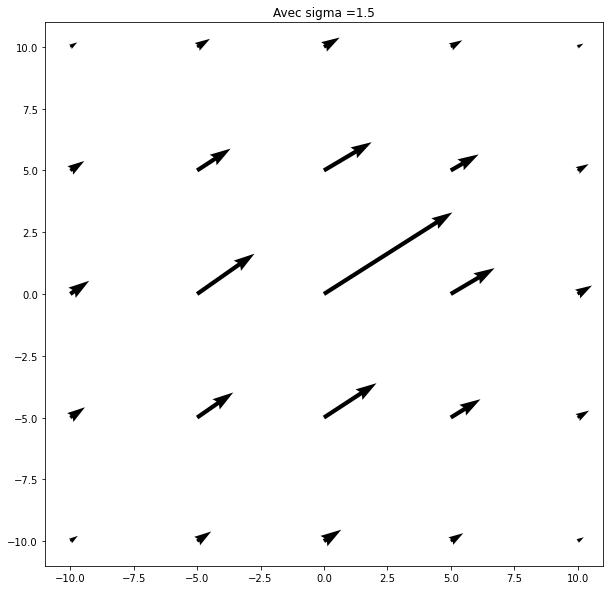

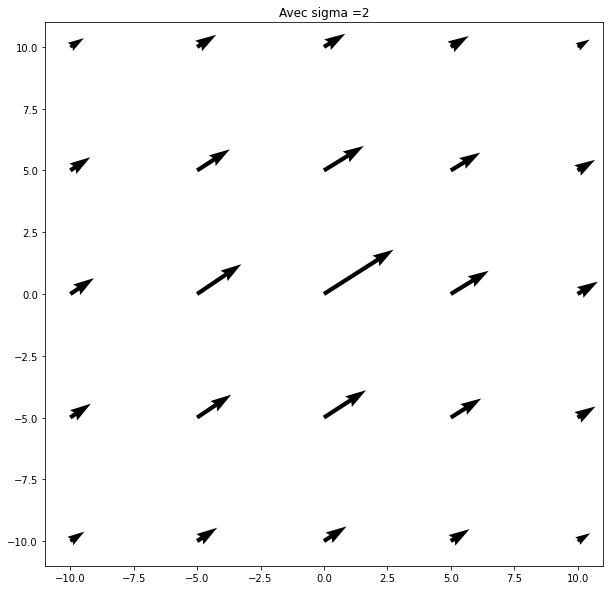

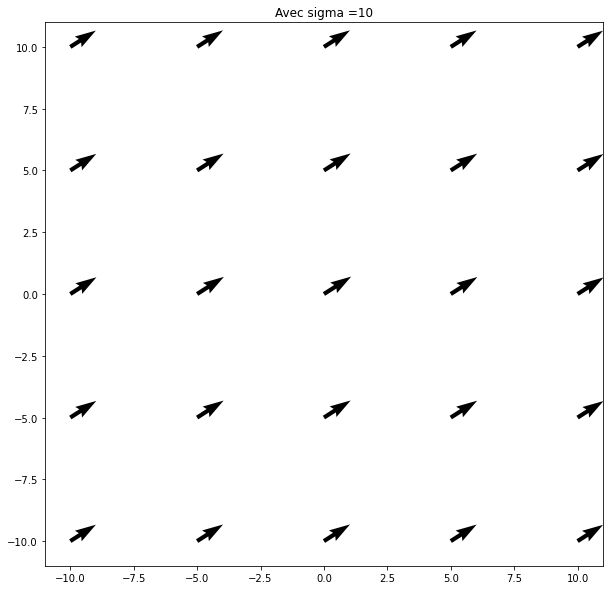

In [505]:
Liste_al2 = np.random.randn(36,2) # une autre liste des alpha, encore au hasard
dessinV(Liste_al2, grille(0.2), 0.2, 0.1, -10, 10)
dessinV(Liste_al2, grille(0.2), 0.2, 0.5, -10, 10)
dessinV(Liste_al2, grille(0.2), 0.2, 0.7, -10, 10)
dessinV(Liste_al2, grille(0.2), 0.2, 1, -10, 10)
dessinV(Liste_al2, grille(0.2), 0.2, 1.5, -10, 10)
dessinV(Liste_al2, grille(0.2), 0.2, 2, -10, 10)
dessinV(Liste_al2, grille(0.2), 0.2, 10, -10, 10)

<div class="alert alert-block alert-info">
Comme vous pouvez le voir au-dessus, n'ayant pour l'instant pas vraiment d'idée sur la liste des alphas, j'ai fait deux tests où elle est choisie au hasard. En faisant varier seulement le paramètre sigma, on voit de nettes différences entre les graphes.
Je n'ai pas passé de temps sur la compréhension de ces graphes, j'attends de pouvoir discuter de l'aspect mathématique avec mes camarades. 
</div>

## Descente de gradient

On va faire une descente de gradient sur :  
$$J : \alpha = (\alpha_1 , ..., \alpha_D) \in (\mathbb{R}^2)^D \mapsto \displaystyle\sum_{k=1} ^{D} |\alpha_k|^2 + \lambda Dist(\varphi_\alpha \cdot S,T)^2 $$

Où : $\varphi_\alpha = I_2 + \displaystyle\sum_{k=1} ^{D} \displaystyle\sum_{l=1} ^{2} v_{k,l}^{\alpha_k (l)}$ et $v_{k,l} : x \mapsto e^{\frac{-|x-z_{k}|^2}{2\sigma^{2}}}e_l$ avec $e_1 = (1,0), e_2 = (0,1)$

<div class="alert alert-block alert-info">
Je commence par définir tout ce qu'il y a juste au-dessus. Pour la définition de Dist, revenir tout en haut de la page.
</div>

In [506]:
def phi_alpha(Lalpha, G, X): #avec X dans R**2
    x,y = X
    for k in range(0,D):
        temp = G[k]
        x += np.exp(((-1)*(np.sqrt(((x-temp[0])**2)+(y-temp[1])**2))/(2*(sigma**2))))**(Lalpha[k][0])
        y += np.exp(((-1)*(np.sqrt(((x-temp[0])**2)+(y-temp[1])**2))/(2*(sigma**2))))**(Lalpha[k][1])
    return x,y

In [507]:
def J(Lalpha, poids, S, T):
    D = len(Lalpha)
    somme = 0
    for k in range(0,D):
        somme += np.linalg.norm(Lalpha[k])**2
    A = [phi_alpha(i) for i in S]
    return somme + poids*dist(A,T)**2

<div class="alert alert-block alert-info">
J'ai des difficultés à implémenter correctement cette descente de gradient, mon objectif est de sortir de la prochaine séance avec une idée claire de comment bien faire.
</div>

In [508]:
def desgrad(J, Lalpha, poids, S, T, lr, eps=1e-6, maxiter=1000):
    # J la fonction 
    # Lalpha liste des alpha
    # lr le taux d'apprentissage (learning rate)
    # eps la précision
    # maxiter le nombre maximum d'itération
    g = 1
    i = 0
    res = Lalpha
    while abs(g)>eps:
        grad = np.gradient(J(Lalpha, poids, S, T)) # soucis ici, j'ai lu la définition de np.gradient et cela devrait correspondre à ce que l'on veut faire
        g =  np.linalg.norm(grad)
        for i in range(0,len(res)):
            res[i] = res[i] - lr*grad[i] # soucis de dimension de grad
        i += 1
        if i > maxiter :
            raise Exception("Nombre d'itérations trop élevé !")
    return res